Our problematic is that density is really respected in our network as long as it evolves.  
We must, therefore, find rules such that it can work properly, having nice and realistic 2D representation.

In [2]:
from gpn6 import GrowingPlanarNetwork, gpn_action
from helper import *
import networkx as nx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from heapq import heappush, heappop

In [3]:
def p_dupl():
    return np.random.random() > 0.46

In [27]:
class RGPN(GrowingPlanarNetwork):
    def init_tissue(self, size=3):
        super().init_tissue(size=size)
        total_size = size**2 - 1
        # set north
        for i in range(size):
            self.G.nodes[i]["side"] = self.G.nodes[i].get("side", set()) | {"N"}
        
        # set south
        for i in range(size):
            self.G.nodes[total_size - i]["side"] = self.G.nodes[total_size - i].get("side", set()) | {"S"}
        
        # set west
        for i in range(size):
            self.G.nodes[i * size]["side"] = self.G.nodes[i * size].get("side", set()) | {"W"}
        
        # set east
        for i in range(size):
            self.G.nodes[total_size - i * size]["side"] = \
                self.G.nodes[total_size - i * size].get("side", set()) | {"E"}
            
    def diffuse_border(self, node):
        # if the border is a corner, we can just return
        # ideally, we shall never have a length of 3 ...
        
        if self.is_border_node(node):
            if len(self.G.nodes[node].get("side", set())) >= 2:
                return
            ngb1, ngb2 = self.get_border_neighbours(node)
            side1 = self.G.nodes[ngb1].get("side", set())
            side2 = self.G.nodes[ngb2].get("side", set())
            side = self.G.nodes[node].get("side", set())
            assert len(side1 & side2) == 1, f"side is not of the right size, " \
                f"should be one : {side1}, {side2}, {ngb1}, {ngb2}" \
                f" with node {node}, {side}"
            self.G.nodes[node]["side"] = side1 & side2
            
        else:
            if "side" in self.G.nodes[node]:
                del self.G.nodes[node]["side"]
    
    def update_corner(self, node):
        if self.is_border_node(node):
            ngb1, ngb2 = self.get_border_neighbours(node)
            side1 = self.G.nodes[ngb1].get("side", set())
            side2 = self.G.nodes[ngb2].get("side", set())
            side_ref = self.G.nodes[node].get("side", set())
            
            if len(side1 & side2) == 0:
                self.G.nodes[ngb1]["side"] = side1 | side2
            
    # TODO override duplicate to set the border (NSEW)
    def duplicate(self, node):
        new_node = super().duplicate(node)
        self.diffuse_border(new_node)
            
    
    # TODO override remove to check for corners
    def destroy(self, node):
        self.update_corner(node)
                
        super().destroy(node)
    
    def edge_swapper(self):
        pass
    
    def update_all_dist(self):
        self.update_dist(direction="N")
        self.update_dist(direction="S")
        self.update_dist(direction="E")
        self.update_dist(direction="W")
        
    def mean_NS(self):
        return np.mean([self.G.nodes[n]["dist_N"] + self.G.nodes[n]["dist_S"] for n in self.G.nodes])
    
    def mean_EW(self):
        return np.mean([self.G.nodes[n]["dist_E"] + self.G.nodes[n]["dist_W"] for n in self.G.nodes])
    
    def update_dist(self, direction="N"):
        """
        Update for each node its distance to each sides
        Direction is one of NSEW
        """
        key = "dist_" + direction
        queue = []
        nodes = set(self.G.nodes)
        # NORTH
        for i in self.G.nodes:
            n = self.G.nodes[i]
            if direction in n.get("side", set()):
                value = 0
            else:
                value = np.inf
                
            n[key] = value
            heappush(queue, (value, i))
            
        while queue and nodes:
            _, inode = heappop(queue)
            if inode not in nodes:
                continue
                
            nodes.remove(inode)
            node = self.G.nodes[inode]
            value = node[key] + 1
            for ngb in node["ngb"]:
                if value < self.G.nodes[ngb][key]:
                    self.G.nodes[ngb][key] = value
                    heappush(queue, (value, ngb))

    
    def show_dist(self, k=5, iterations=1000, figsize=(10, 10), pos=None, hl_nodes=[]):
        # green for NS, red for EW
        plt.figure(figsize=figsize)
        if not pos:
            pos = nx.spring_layout(self.G, k=k, iterations=iterations)
        green = lambda x: format(max(0, 255 - (x["dist_N"] + x["dist_S"]) * 20), '02x')
        red = lambda x: format(max(0, 255 - (x["dist_E"] + x["dist_W"]) * 20), '02x')
        corner = lambda x: len(x.get("side", set())) >= 2
        
        def col_border(node):
            side = tuple(node.get("side", set()))
            return {
                ("N",): "#888822",  # yellow
                ("S",): "#228888",  # cyan
                ("E",): "#882288",  # purple
                ("W",): "#666666",  # grey
            }.get(side, "")
        
        def col_other(n):
            if n in hl_nodes:
                return "#FF4444"  # red
            return "#" + red(self.G.nodes[n]) + green(self.G.nodes[n]) + "ff"
            
        colors = ["#000000" if corner(self.G.nodes[n]) else 
                  col_border(self.G.nodes[n])
                  or col_other(n) for n in self.G.nodes]
        
        nx.draw_networkx(self.G, pos, node_color=colors)
        
    def _reduce_on_axis(self, n, axis):
        """
        Warning, non node-cycle reducing, taking one step further
        Rationale is that empirically, we did not find much into cycle opportunity
        But we will have to do it later
        """
        assert axis in ["NS", "EW"], "Wrong axis argument"
        
        if self._quick_reduce(n, axis):
            print("Quick reducing", n, "on", axis)
            return True
        
        distA, distB = ("dist_N", "dist_S") if axis == "NS" else ("dist_E", "dist_W")
        node = self.G.nodes[n]
        N, S = node[distA], node[distB]
        ingbs = set(self.get_intermediate_neighbours(n)) - {-1}
        
        candidate_list = list()
        
        for ingb in ingbs:
            dngbs = self.ngb(ingb, net="dual")
            
            for edge_dngb in dngbs:
                node_dngb = self.get_other_node(edge_dngb, ingb)
                if node_dngb in (set(ingbs) | {-1}):
                    continue
                    
                # if #ngb == 2
                p_edge = self.dual(edge_dngb)
                if len(self.ngb(p_edge[0])) == 2 or len(self.ngb(p_edge[1])) == 2:
                    continue
                    
                pngbs = self.get_intermediate_neighbours(node_dngb, net="dual")
                
                # the best thing would be to make a list of possible
                # candidates then pick the very best, the same way as 
                # _augment
                for pngb in pngbs:
                    # no edge
                    if (n, pngb) in self.G.edges:
                        continue

                    pnode = self.G.nodes[pngb]
                    pN, pS = pnode[distA], pnode[distB]

                    # nothing to win (here for NS but works also for EW)
                    if pN >= N - 1 and pS >= S - 1:
                        continue
                        
                    candidate_list.append((self.dual(edge_dngb), pngb))
                    
        if len(candidate_list) == 0:
            print(f"No candidates for node {n} in _reduce")
            return False

        candidate_list.sort(key=lambda x: len(self.ngb(x[1])))

        p_edge, pngb = candidate_list[0]
        print(f"Reducing node {n}")
        self.replace_edge(p_edge, (n, pngb))
        return True
                
    def _get_border_candidates(self, node):
        assert self.is_border_node(node)
        return [n for ngb in gpn.get_border_neighbours(node)
                for n in gpn.get_border_neighbours(ngb)
                if n != node]
    
    def _get_quick_candidates(self, node, dual_node):
        assert dual_node != -1, "Operation not allowed for dual -1"
        return [ngb for ngb in 
                self.get_intermediate_neighbours(dual_node, net="dual")
                if ngb != node]
    
    def _get_common_border_ngb(self, n_a, n_b):
        s_a = set(gpn.get_border_neighbours(n_a))
        s_b = set(gpn.get_border_neighbours(n_b))
        return list(s_a & s_b)[0]
                
    def _quick_reduce(self, n, axis):
        """
        The idea is the same as "_reduce_on_axis" but here
        we just create a direct edge without removing anything
        directly (maybe something will be removed through
        stabilize_ngb later)
        """
        assert axis in ["NS", "EW"], "Wrong axis argument"
        
        A, B = axis
        node = self.G.nodes[n]
        N, S = self._dist(n, A), self._dist(n, B)
        dist = self._dist(n, axis)
        # get dual nodes
        ingbs = self.get_intermediate_neighbours(n)
        
        # gather all candidates without any filter
        candidates = []
        for ingb in ingbs:
            if ingb == -1:
                ls_c = self._get_border_candidates(n)
            else:
                ls_c = self._get_quick_candidates(n, ingb)
            candidates += [(c, ingb) for c in ls_c]
                
        # filter candidates
        filtered_candidates = [(c, d) for c, d in candidates
                               if self._dist(c, A) < N - 1
                               or self._dist(c, B) < S - 1]
        
        # pick best
        random.shuffle(filtered_candidates)
        
        # TODO number of ngb does not correct for already ngb with the next removed edge
        # neither border sides
        filtered_candidates.sort(key=lambda x: len(self.ngb(x[0])))

        # if empty
        if len(filtered_candidates) == 0:
            return False
            
        # select the best one (the first)
        candidate, dual = filtered_candidates[0]
        self.build_new_edge(n, candidate, dual)
        return True
        
    def build_new_edge(self, n, candidate, dual):
        if dual == -1:
            ref_node = self._get_common_border_ngb(n, candidate)
            if self.is_corner(ref_node):
                self.update_corner(ref_node)
            self._make_border_edge(ref_node, (n, candidate))
            self.diffuse_border(ref_node)
        else:
            self._make_edge(dual, (n, candidate))
            
        return True
                
    @gpn_action
    def replace_edge(self, edge1, edge2):
        dual_node = self._remove_edge(edge1)
        # print("Dual node", dual_node)
        self._make_edge(dual_node, edge2)
        
    def shorten_dist(self):
        """
        For now, one max action per round, otherwise tricky mechanisms could occur
        """
        self.update_all_dist()
        mean_NS = self.mean_NS()
        mean_EW = self.mean_EW()
        # find nodes with most pressure
        # for threshold, let's say *1.5 compared to mean
        nodes = list(self.G.nodes)
        random.shuffle(nodes)
        # TODO we must sort from the most "out" to the less
        # list candidates
        candidates = list()
        for n in nodes:
            node = self.G.nodes[n]
            val_NS = (node["dist_N"] + node["dist_S"]) / mean_NS
            val_EW = (node["dist_E"] + node["dist_W"]) / mean_EW
            if val_NS >= 1.1:
                candidates.append((n, "NS", val_NS))
                
            if val_EW >= 1.1:
                candidates.append((n, "EW", val_EW))
            
        # pick best candidate
        candidates.sort(key=lambda x: x[2], reverse=True)
        for n, axis, _ in candidates:
            if self._reduce_on_axis(n, axis=axis):
                self.check_all()
                self.stabilize_around(n)
                return True
            
            else:
                print(f"Impossible shorten for node {n} on axis {axis}")
        
        # success is implicit
        return False
                
    def maxen_dist(self):
        self.update_all_dist()
        mean_NS = self.mean_NS()
        mean_EW = self.mean_EW()
        # find nodes with most pressure
        # for threshold, let's say *1.5 compared to mean
        nodes = list(self.G.nodes)
        random.shuffle(nodes)
        candidates = list()
        for n in nodes:
            node = self.G.nodes[n]
            val_NS = (node["dist_N"] + node["dist_S"]) / mean_NS
            val_EW = (node["dist_E"] + node["dist_W"]) / mean_EW
            if val_NS <= 0.9:
                candidates.append((n, "NS", val_NS))
                
            if val_EW <= 0.9:
                candidates.append((n, "EW", val_EW))
            
        # pick best candidate
        candidates.sort(key=lambda x: x[2], reverse=False)
        for n, axis, _ in candidates:
            if self._augment(n, axis=axis):
                self.stabilize_around(n)
                return True
        
        # success is implicit
        return False
    
    def get_all_dists(self):
        l_NS, l_EW, l_both = list(), list(), list()
        nodes = list(self.G.nodes)
        candidates = list()
        for n in nodes:
            node = self.G.nodes[n]
            val_NS = (node["dist_N"] + node["dist_S"])
            val_EW = (node["dist_E"] + node["dist_W"])
            l_NS.append(val_NS)
            l_EW.append(val_EW)
            l_both.append(val_NS + val_EW)
            
        return l_NS, l_EW, l_both
    
    def print_dist_metrics(self):
        lA, lB, lC = self.get_all_dists()
        xA, xB, xC = np.std(lA) / np.mean(lA), np.std(lB) / np.mean(lB), np.std(lC) / np.mean(lC)
        print(f"Score are for NS : {xA}, EW : {xB}, both : {xC}")
        return xA + xB + xC

    @gpn_action
    def setup_edge(self, edge, dual_node, candidate):
        # setup the edge and delete the one chosen
        node1, node2 = edge
        if (node1, candidate) not in self.G.edges:
            other_dual = self._make_edge(dual_node, (node1, candidate))
            # update dual_node
            ingb = set(self.get_intermediate_neighbours(dual_node, net="dual"))
            if not ingb.issuperset({node2, candidate}):
                dual_node, other_dual = other_dual, dual_node
            
        if (node2, candidate) not in self.G.edges:
            self._make_edge(dual_node, (node2, candidate))
        
        self._remove_edge(edge)
        self.diffuse_border(candidate)
    
    # TODO, find a better way
    def _dist(self, n, axis):
        node = self.G.nodes[n]
        return sum([node["dist_" + str(x)] for x in axis])
                
    def _augment(self, n, axis="NS"):
        A, B = axis
        node = self.G.nodes[n]
        N, S = self._dist(n, A), self._dist(n, B)
        dist = self._dist(n, axis)
        target_node = None
        # first step, find ngb that has the same dist
        for ngb in self.ngb(n):
            if self._dist(ngb, axis) <= dist:
                target_node = ngb
                break
                
        # stop here if #ngb == 2
        if len(self.ngb(n)) == 2 or len(self.ngb(target_node)) == 2:
            return False
                
        if target_node == None:
            raise RuntimeError(f"Should not have no ngb with same dist, dist is {dist}")
            
        dual_nodes = set(self.dual((n, target_node))[:2]) - {-1}
        
        # build list of candidate link node
        candidate_list = []
        for dual_node in dual_nodes:
            pngbs = set(self.get_intermediate_neighbours(dual_node, net="dual")) - {n, target_node}
            candidate_list += [(dual_node, pngb) for pngb in pngbs 
                               if self._dist(pngb, A) >= N and self._dist(pngb, B) >= S]
            
        random.shuffle(candidate_list)
        # TODO number of ngb does not correct for already ngb with the next removed edge
        candidate_list.sort(key=lambda x: len(self.ngb(x[1])))

        # if empty
        if len(candidate_list) == 0:
            return False
            
        # select the best one (the first)
        dual, candidate = candidate_list[0]
        
        self.setup_edge((n, target_node), dual, candidate)
        return True
    
    def is_useless_edge(self, edge):
        return (self.use_other_node(edge[0], edge[1]) or
                self.use_other_node(edge[1], edge[0]))
    
    def use_other_node(self, node1, node2):
        # test for each direction that you can find
        # the proper value of dist
        nodes = set(self.ngb(node1)) - {node2}
        for d in ["dist_E", "dist_W", "dist_N", "dist_S"]:
            for n in nodes:
                if self.G.nodes[node2][d] == self.G.nodes[n][d] + 1:
                    continue
            return False
        return True
    
    def remove_useless_edge(self):
        edges = list(self.G.edges)
        random.shuffle(edges)
        
        for e in edges:
            if self.is_useless_edge(e):
                self._remove_edge(e)
                return True

In [47]:
def node_pos(node):
    x = node["dist_N"] / (node["dist_N"] + node["dist_S"])
    y = node["dist_E"] / (node["dist_E"] + node["dist_W"])
    x, y = (x - 0.5) * 1.5, (y - 0.5) * 1.5
    return np.array([x, y])

def embedded_viz(gpn):
    gpn.update_all_dist()
    # pos is a dict of np array with coordinates
    pos = {n: node_pos(gpn.G.nodes[n]) for n in gpn.G.nodes}
    return pos

def quick_export(gpn, pos, name, useful=None):
    global ignore_export
    if ignore_export:
        return
    gpn.update_all_dist()
    gpn.show_dist(pos=pos, figsize=(8, 8))
    color = {True: "green", False: "red"}.get(useful, "grey")
    rect = plt.Rectangle((-0.825, 0.750), 0.075, 0.075, fc=color)
    plt.gca().add_patch(rect)
    plt.savefig(name)
    plt.close()
    
def print_run(i):
    print()
    print("-" * 50)
    print()
    print(f"Run {i}")
    
def get_pathological_nodes_1(gpn):
    # delta dist with ngb >= 2 in one direction
    pathological_nodes = list()
    for n in gpn.G.nodes:
        ref = gpn._dist(n, axis="NS"), gpn._dist(n, axis="EW")
        # calc center of mass of ngbs
        for ngb in gpn.ngb(n):
            d = gpn._dist(n, axis="NS"), gpn._dist(n, axis="EW")
            if (d[0] >= ref[0] + 2) or (d[0] >= ref[0] + 2):
                pathological_nodes.append(n)
                break
            
    return pathological_nodes

def get_pathological_nodes_2(gpn):
    # center of gravity too much "out"
    pathological_nodes = list()
    for n in gpn.G.nodes:
        if gpn.is_border_node(n):
            continue
        c = np.array([0, 0])
        # calc center of mass of ngbs
        for i, ngb in enumerate(gpn.ngb(n)):
            node = gpn.G.nodes[ngb]
            c = c + node_pos(node)
        c = c[0] / (i + 1), c[1] / (i + 1)
        
        # compare
        node = gpn.G.nodes[n]
        ref = node_pos(node)
        dist = np.sqrt((c[0] - ref[0])**2 + (c[1] - ref[1])**2)

        if dist > 0.1:
            pathological_nodes.append(n)
            
    return pathological_nodes

def get_marginal_nodes(gpn, thr=1.1):
    test = (lambda x: x > thr) if thr > 1 else (lambda x: x < thr)
    mean_NS, mean_EW = gpn.mean_NS(), gpn.mean_EW()
    
    candidates = list()
    for n in gpn.G.nodes:
        node = gpn.G.nodes[n]
        val_NS = (node["dist_N"] + node["dist_S"]) / mean_NS
        val_EW = (node["dist_E"] + node["dist_W"]) / mean_EW
        if test(val_NS):
            candidates.append(n)

        if test(val_EW):
            candidates.append(n)
            
    return candidates

In [49]:
hl = get_marginal_nodes(gpn)
hl

[74, 110]

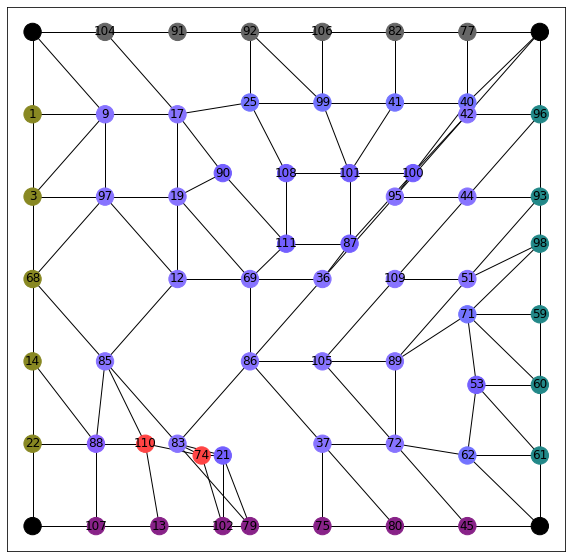

In [50]:
pos = embedded_viz(gpn)
gpn.show_dist(pos=pos, hl_nodes=hl)

In [34]:
seed = 2
random.seed(seed)
np.random.seed(seed)
gpn = RGPN()
gpn.debug = True
gpn.init_tissue(8)
gpn.update_all_dist()
ignore_export = False

pos = nx.spring_layout(gpn.G, k=0.1, iterations=50)
root = "output/evonet8/"
ratio = 0
for i in range(150):
    print_run(i)
    if i < 100:
        if p_dupl():
            ratio += 1
            gpn.duplicate_random()
        else:
            ratio -= 1
            gpn.destroy_random()
        
    pos = embedded_viz(gpn)
    quick_export(gpn, pos, root + str(i).zfill(4) + "_a.png")
    
    print("Action")
    gpn.update_all_dist()
    dist_score = gpn.print_dist_metrics()

    if gpn.shorten_dist():
        pos = embedded_viz(gpn)
        print("Shorten")
        gpn.update_all_dist()
        sc = gpn.print_dist_metrics()
        quick_export(gpn, pos, root + str(i).zfill(4) + "_b.png", useful=sc < dist_score)
        dist_score = sc

    if gpn.maxen_dist():
        pos = embedded_viz(gpn)
        print("Maxen")
        gpn.update_all_dist()
        sc = gpn.print_dist_metrics()
        quick_export(gpn, pos, root + str(i).zfill(4) + "_c.png", useful=sc < dist_score)
        dist_score = sc
        
    if gpn.remove_useless_edge():
        pos = embedded_viz(gpn)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_d.png")
        print("AAAAAAAAAAAAAA - Remuseless")
        gpn.update_all_dist()
        gpn.print_dist_metrics()
        
    if i % 100 == 0:
        print()
        print("Iteration", i, "ratio", ratio, "density", gpn.density())

Calling _init_square  with  () {'size': 8}

--------------------------------------------------

Run 0
Calling _destroy_node  with  (7,) {}
Action
Score are for NS : 0.0, EW : 0.04561979233461597, both : 0.022627416997969524
Calling setup_edge  with  ((5, 4), 4, 13) {}
Maxen
Score are for NS : 0.06133864568481871, EW : 0.038182480641090595, both : 0.03826642173766337

Iteration 0 ratio -1 density 0.08035714285714286

--------------------------------------------------

Run 1
Calling _destroy_node  with  (6,) {}
Action
Score are for NS : 0.0710479455260107, EW : 0.03845545106180895, both : 0.04322054610216424
Quick reducing 10 on EW
Shorten
Score are for NS : 0.0710479455260107, EW : 0.025124887958952576, both : 0.03843856035825846

--------------------------------------------------

Run 2
Calling _destroy_node  with  (59,) {}
Action
Score are for NS : 0.07138609234576078, EW : 0.054244185508339315, both : 0.04708596301840079
Quick reducing 11 on EW
Shorten
Score are for NS : 0.0713860923

Action
Score are for NS : 0.10388276273098586, EW : 0.11048713684138715, both : 0.08875417969550162
Quick reducing 67 on NS
Shorten
Score are for NS : 0.0991514642354193, EW : 0.11048713684138715, both : 0.08585253340622888
Calling setup_edge  with  ((32, 40), 74, 41) {}
Maxen
Score are for NS : 0.10046030162705488, EW : 0.12503681807742212, both : 0.09904532959244722

--------------------------------------------------

Run 20
Calling _destroy_node  with  (9,) {}
Action
Score are for NS : 0.09038244094776356, EW : 0.12132865430434303, both : 0.0923760430703401
Quick reducing 68 on EW
Shorten
Score are for NS : 0.09038244094776356, EW : 0.11737089201877933, both : 0.09054081288152664
Calling setup_edge  with  ((50, 42), 80, 49) {}
Maxen
Score are for NS : 0.09001646614570412, EW : 0.11737089201877933, both : 0.08941807583761448

--------------------------------------------------

Run 21
Calling _duplicate_node  with  (49,) {}
Action
Score are for NS : 0.09668177903586284, EW : 0.1175792

Calling setup_edge  with  ((45, 43), 113, 37) {}
Maxen
Score are for NS : 0.10670071017217521, EW : 0.15035529189479432, both : 0.1096594077168272

--------------------------------------------------

Run 38
Calling _destroy_node  with  (55,) {}
Action
Score are for NS : 0.10390402198971876, EW : 0.15073300358850053, both : 0.10811603729846991
Quick reducing 76 on NS
Shorten
Score are for NS : 0.10390402198971876, EW : 0.15073300358850053, both : 0.10811603729846991
Calling setup_edge  with  ((63, 47), 107, 46) {}
Maxen
Score are for NS : 0.10946338099604615, EW : 0.15508114730638536, both : 0.10860009890180342

--------------------------------------------------

Run 39
Calling _destroy_node  with  (32,) {}
Action
Score are for NS : 0.1300627629802227, EW : 0.1585525223429382, both : 0.10743144774279856
Quick reducing 76 on NS
Shorten
Score are for NS : 0.1300627629802227, EW : 0.1585525223429382, both : 0.10743144774279856
Calling setup_edge  with  ((25, 10), 87, 70) {}
Maxen
Score are

Action
Score are for NS : 0.22831162973959176, EW : 0.10224454328488987, both : 0.1377522765255346
Quick reducing 73 on NS
Shorten
Score are for NS : 0.22459235691632976, EW : 0.1027768646899453, both : 0.13581344075600196
Calling setup_edge  with  ((36, 82), 150, 37) {}
Maxen
Score are for NS : 0.16673719455246497, EW : 0.1027768646899453, both : 0.11347229820025631

--------------------------------------------------

Run 55
Calling _duplicate_node  with  (29,) {}
Action
Score are for NS : 0.16570889936195932, EW : 0.09930363822093964, both : 0.11256984289302926
Quick reducing 81 on NS
Shorten
Score are for NS : 0.16570889936195932, EW : 0.09930363822093964, both : 0.11256984289302926
Calling setup_edge  with  ((84, 89), 151, 21) {}
Quasi lonely node 84 with #ngbs = 2
Maxen
Score are for NS : 0.16570889936195932, EW : 0.07227634382894418, both : 0.09883257428262723

--------------------------------------------------

Run 56
Calling _destroy_node  with  (43,) {}
Action
Score are for NS

Calling setup_edge  with  ((28, 27), 164, 34) {}
Maxen
Score are for NS : 0.1485893816792643, EW : 0.14681368936967243, both : 0.1299475254298907

--------------------------------------------------

Run 71
Calling _duplicate_node  with  (96,) {}
Action
Score are for NS : 0.1596033470695157, EW : 0.14555898794302702, both : 0.13166991011590728
Quick reducing 1 on EW
Shorten
Score are for NS : 0.1596033470695157, EW : 0.14179943271949885, both : 0.13011360176630168
Calling setup_edge  with  ((28, 34), 174, 27) {}
Maxen
Score are for NS : 0.1596033470695157, EW : 0.11978733166359692, both : 0.11807778510265127

--------------------------------------------------

Run 72
Calling _duplicate_node  with  (45,) {}
Action
Score are for NS : 0.17522409808481934, EW : 0.1230260980253761, both : 0.1288388490937911
Quick reducing 81 on NS
Shorten
Score are for NS : 0.1707529244772814, EW : 0.1230260980253761, both : 0.12690020482689135
Calling setup_edge  with  ((88, 89), 96, 15) {}
Maxen
Score are 

Calling setup_edge  with  ((76, 64), 189, 74) {}
Maxen
Score are for NS : 0.19138091429185464, EW : 0.17317269949025504, both : 0.17060644828172497

--------------------------------------------------

Run 88
Calling _duplicate_node  with  (68,) {}
Quasi lonely node 68 with #ngbs = 2
Action
Score are for NS : 0.19353796370617143, EW : 0.17735627839280058, both : 0.1742052523409938
Quick reducing 106 on NS
Shorten
Score are for NS : 0.19353796370617143, EW : 0.17735627839280058, both : 0.1742052523409938
Calling setup_edge  with  ((74, 64), 201, 76) {}
Removing crossing border edge 76 46 (163, 140, 0)
Maxen
Score are for NS : 0.1729957805907173, EW : 0.1768794908918525, both : 0.16417731861503923

--------------------------------------------------

Run 89
Calling _destroy_node  with  (102,) {}
Action
Score are for NS : 0.17417702907899593, EW : 0.17784697508540234, both : 0.16513294315752913
Reducing node 1
Calling replace_edge  with  ((85, 24), (1, 69)) {}
Shorten
Score are for NS : 0.1


--------------------------------------------------

Run 104
Action
Score are for NS : 0.2675909906398288, EW : 0.1533525088849615, both : 0.17922897028590262
Quick reducing 45 on NS
Shorten
Score are for NS : 0.26294733482195304, EW : 0.1533525088849615, both : 0.17752501135285265
Calling setup_edge  with  ((51, 50), 264, 28) {}
Maxen
Score are for NS : 0.2884375804778883, EW : 0.14249628499678846, both : 0.18290546437635571

--------------------------------------------------

Run 105
Action
Score are for NS : 0.2884375804778883, EW : 0.14249628499678846, both : 0.18290546437635571
Quick reducing 100 on NS
Shorten
Score are for NS : 0.2884375804778883, EW : 0.14249628499678846, both : 0.18290546437635571
Calling setup_edge  with  ((84, 21), 211, 20) {}
Maxen
Score are for NS : 0.2910511017014931, EW : 0.1444824750816851, both : 0.18793315078778147

--------------------------------------------------

Run 106
Action
Score are for NS : 0.2910511017014931, EW : 0.1444824750816851, both : 

Action
Score are for NS : 0.2453628892041662, EW : 0.21166010488516726, both : 0.2038868280820756
Quick reducing 53 on NS
Shorten
Score are for NS : 0.2453628892041662, EW : 0.21166010488516726, both : 0.2038868280820756
Calling setup_edge  with  ((84, 51), 285, 95) {}
Maxen
Score are for NS : 0.22184632591091757, EW : 0.20948278220093214, both : 0.1867601824399327

--------------------------------------------------

Run 123
Action
Score are for NS : 0.22184632591091757, EW : 0.20948278220093214, both : 0.1867601824399327
Reducing node 94
Calling replace_edge  with  ((42, 73), (94, 48)) {}
Shorten
Score are for NS : 0.2172158407784651, EW : 0.20948278220093214, both : 0.18587810200174748
Calling setup_edge  with  ((51, 50), 286, 28) {}
Maxen
Score are for NS : 0.23578310673991287, EW : 0.18156577598370638, both : 0.18330627273799582

--------------------------------------------------

Run 124
Action
Score are for NS : 0.23578310673991287, EW : 0.18156577598370638, both : 0.183306272737


--------------------------------------------------

Run 141
Action
Score are for NS : 0.2498288817595803, EW : 0.22417858141095737, both : 0.21857387765587274
Quick reducing 53 on EW
Shorten
Score are for NS : 0.2498288817595803, EW : 0.22417858141095737, both : 0.21857387765587274
Calling setup_edge  with  ((15, 95), 319, 88) {}
Maxen
Score are for NS : 0.2498288817595803, EW : 0.17721444263289024, both : 0.19798129454717997

--------------------------------------------------

Run 142
Action
Score are for NS : 0.2498288817595803, EW : 0.17721444263289024, both : 0.19798129454717997
Quick reducing 53 on EW
Shorten
Score are for NS : 0.2498288817595803, EW : 0.17721444263289024, both : 0.19798129454717997
Calling setup_edge  with  ((28, 50), 286, 51) {}
Maxen
Score are for NS : 0.24501520355471484, EW : 0.18787390604146595, both : 0.20048290444564218

--------------------------------------------------

Run 143
Action
Score are for NS : 0.24501520355471484, EW : 0.18787390604146595, bot

## Rollback

In [29]:
seed = 2
random.seed(seed)
np.random.seed(seed)
gpn = RGPN()
gpn.debug = True
gpn.init_tissue(8)
gpn.update_all_dist()
ignore_export = True

pos = nx.spring_layout(gpn.G, k=0.1, iterations=50)
root = "output/evonet8/"
ratio = 0
for i in range(150):
    print_run(i)
    if i < 100:
        if p_dupl():
            ratio += 1
            gpn.duplicate_random()
        else:
            ratio -= 1
            gpn.destroy_random()
        
    pos = embedded_viz(gpn)
    quick_export(gpn, pos, root + str(i).zfill(4) + "_a.png")
    
    print("Action")
    gpn.update_all_dist()
    dist_score = gpn.print_dist_metrics()
    back = gpn.copy()

    if gpn.shorten_dist():
        pos = embedded_viz(gpn)
        print("Shorten")
        gpn.update_all_dist()
        sc = gpn.print_dist_metrics()
        if not sc < dist_score:
            print("Rollback")
            gpn = back
        else:
            quick_export(gpn, pos, root + str(i).zfill(4) + "_b.png", useful=sc < dist_score)
            dist_score = sc
            
    back = gpn.copy()

    if gpn.maxen_dist():
        pos = embedded_viz(gpn)
        print("Maxen")
        gpn.update_all_dist()
        sc = gpn.print_dist_metrics()
        if not sc < dist_score:
            print("Rollback")
            gpn = back
        else:
            quick_export(gpn, pos, root + str(i).zfill(4) + "_c.png", useful=sc < dist_score)
            dist_score = sc
        
    if gpn.remove_useless_edge():
        pos = embedded_viz(gpn)
        quick_export(gpn, pos, root + str(i).zfill(4) + "_d.png")
        print("AAAAAAAAAAAAAA - Remuseless")
        gpn.update_all_dist()
        gpn.print_dist_metrics()
        
    if i % 100 == 0:
        print()
        print("Iteration", i, "ratio", ratio, "density", gpn.density())

Calling _init_square  with  () {'size': 8}

--------------------------------------------------

Run 0
Calling _destroy_node  with  (7,) {}
Action
Score are for NS : 0.0, EW : 0.04561979233461597, both : 0.022627416997969524
Calling setup_edge  with  ((5, 4), 4, 13) {}
Maxen
Score are for NS : 0.06133864568481871, EW : 0.038182480641090595, both : 0.03826642173766337
Rollback

Iteration 0 ratio -1 density 0.08641975308641975

--------------------------------------------------

Run 1
Action
Score are for NS : 0.0459517959492941, EW : 0.0459517959492941, both : 0.03303685241139552
Maxen
Score are for NS : 0.06336953721886278, EW : 0.03044424415480565, both : 0.03642162913112125
Rollback

--------------------------------------------------

Run 2
Action
Score are for NS : 0.04629100498862757, EW : 0.06211019534324773, both : 0.03952479623806562
Maxen
Score are for NS : 0.05761729364990044, EW : 0.07618388046902588, both : 0.051354917078358715
Rollback

--------------------------------------

Shorten
Score are for NS : 0.08680222369721391, EW : 0.13668816949684132, both : 0.08141747194602704
Rollback
Maxen
Score are for NS : 0.08372892692676742, EW : 0.10077103747810456, both : 0.06442915602351186

--------------------------------------------------

Run 32
Action
Score are for NS : 0.08890818716835228, EW : 0.10169139933964844, both : 0.06986856351475795
Quick reducing 76 on NS
Shorten
Score are for NS : 0.08608956717807588, EW : 0.11407492032847383, both : 0.0776947939151393
Rollback
Maxen
Score are for NS : 0.09040235495884187, EW : 0.07849026631535026, both : 0.06905762398065018

--------------------------------------------------

Run 33
Action
Score are for NS : 0.1236172608219381, EW : 0.07790516591364824, both : 0.0825001252733265
Quick reducing 47 on EW
Shorten
Score are for NS : 0.11807370099130668, EW : 0.0677455038254263, both : 0.074417414627359
Maxen
Score are for NS : 0.08515067163720148, EW : 0.10708890217702743, both : 0.07493997199098203
Rollback

----------

Shorten
Score are for NS : 0.08344022836223418, EW : 0.0730272995011082, both : 0.06013426994989339
Maxen
Score are for NS : 0.06214134519017389, EW : 0.06663225755115795, both : 0.047942216247284314

--------------------------------------------------

Run 55
Action
Score are for NS : 0.0703405708843471, EW : 0.06785335583128085, both : 0.050332644296088344
Quick reducing 53 on NS
Shorten
Score are for NS : 0.0654155307457057, EW : 0.06785335583128085, both : 0.048773893975814706

--------------------------------------------------

Run 56
Action
Score are for NS : 0.09048738723231546, EW : 0.08897565210026094, both : 0.06795010511156736
Quick reducing 41 on EW
Shorten
Score are for NS : 0.08858198246062539, EW : 0.08509243693702691, both : 0.06795010511156736
Maxen
Score are for NS : 0.08858198246062539, EW : 0.06820598042397355, both : 0.06013771479251045

--------------------------------------------------

Run 57
Action
Score are for NS : 0.0887620289597153, EW : 0.07273929674533079,


--------------------------------------------------

Run 79
Action
Score are for NS : 0.06553601370622293, EW : 0.09087005688454836, both : 0.0639863362179646
Quick reducing 40 on EW
Shorten
Score are for NS : 0.06553601370622293, EW : 0.08626974201281466, both : 0.06310160929886406

--------------------------------------------------

Run 80
Action
Score are for NS : 0.06674829783581462, EW : 0.09877027637465248, both : 0.06745793014928837
Quick reducing 101 on EW
Shorten
Score are for NS : 0.06674829783581462, EW : 0.09072184232530289, both : 0.06484497627141764

--------------------------------------------------

Run 81
Action
Score are for NS : 0.07204437286590896, EW : 0.09055707818532831, both : 0.0646980672712608
Quick reducing 87 on EW
Shorten
Score are for NS : 0.07257280694875884, EW : 0.08619459651541776, both : 0.06242036869194836

--------------------------------------------------

Run 82
Quasi lonely node 50 with #ngbs = 2
Action
Score are for NS : 0.07531859346386767, EW 


--------------------------------------------------

Run 107
Action
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Quick reducing 74 on NS
Shorten
Score are for NS : 0.07257280694875884, EW : 0.10440083147818849, both : 0.06923430096239917
Rollback

--------------------------------------------------

Run 108
Action
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Quick reducing 110 on NS
Shorten
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Rollback

--------------------------------------------------

Run 109
Action
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Quick reducing 74 on NS
Shorten
Score are for NS : 0.07257280694875884, EW : 0.10440083147818849, both : 0.06923430096239917
Rollback

--------------------------------------------------

Run 110
Action
Score are for NS : 0.07137401846894628, EW : 0

Shorten
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Rollback

--------------------------------------------------

Run 138
Action
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Quick reducing 74 on NS
Shorten
Score are for NS : 0.07257280694875884, EW : 0.10440083147818849, both : 0.06923430096239917
Rollback

--------------------------------------------------

Run 139
Action
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Quick reducing 110 on NS
Shorten
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Rollback

--------------------------------------------------

Run 140
Action
Score are for NS : 0.07137401846894628, EW : 0.07666455436830104, both : 0.05722878034813959
Quick reducing 74 on NS
Shorten
Score are for NS : 0.07257280694875884, EW : 0.10440083147818849, both : 0.06923430096239917
Rollback

---

(array([ 9., 21., 16., 12.,  9.,  8., 12.,  3.,  5.,  1.]),
 array([ 9. , 10.9, 12.8, 14.7, 16.6, 18.5, 20.4, 22.3, 24.2, 26.1, 28. ]),
 <BarContainer object of 10 artists>)

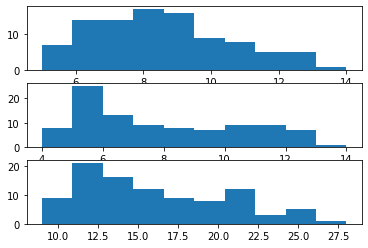

In [36]:
lA, lB, lC = gpn.get_all_dists()
plt.subplot(3, 1, 1)
plt.hist(lA)
plt.subplot(3, 1, 2)
plt.hist(lB)
plt.subplot(3, 1, 3)
plt.hist(lC)

In [37]:
raise

RuntimeError: No active exception to reraise

In [ ]:
for x in [(-1, 117, 1), (117, 118, 0), (118, 47, 0), (-1, 120, 0), (120, 47, 0)]:
    print(gpn.dual(x))

In [ ]:
gpn.G.nodes[9], gpn.G.nodes[8], gpn.G.nodes[0]

In [ ]:
gpn.show_all()

In [ ]:
pos = nx.spring_layout(gpn.G, pos=pos, k=0.1, iterations=10)
gpn.update_all_dist()
gpn.show_dist(pos=pos, figsize=(8, 8))

In [ ]:
gpn.dual((125, 15)), gpn.ngb(15), gpn.ngb(7), gpn.dual((125, 7))

In [ ]:
raise

In [ ]:
list_inner = [gpn.G.degree(n) for n in gpn.G.nodes if not gpn.is_border_node(n)]
list_outer = [gpn.G.degree(n) for n in gpn.G.nodes if gpn.is_border_node(n)]

In [ ]:
plt.hist(list_inner)

In [ ]:
plt.hist(list_outer)

In [ ]:
gpn.show_all()

In [ ]:
raise

In [ ]:
# test 1
def test_func():
    gpn = GrowingPlanarNetwork()
    gpn.init_square(8)
    for i in range(500):
        if p_dupl():
            gpn.duplicate_random_node()
        else:
            gpn.remove_random_node()
    dist = np.array(list(nx.betweenness_centrality(gpn.G).values()))
    return (skew(dist), kurtosis(dist), gpn.G, gpn.D)

for i in range(10):
    S, K, G, D = test_func()
    print(G.size(), D.degree(-1))

In [ ]:
G = gpn.G

In [ ]:
pos = nx.spring_layout(G, k=0.1, iterations=50)
pos = nx.planar_layout(gpn.G)
plt.figure(figsize=(12, 12))
nx.draw_networkx(gpn.G, pos=pos)

In [ ]:
pos = nx.planar_layout(Gstart)
plt.figure(figsize=(12, 12))
nx.draw_networkx(Gstart, pos=pos)

In [ ]:
raise

In [ ]:
gpn.show_all()

In [ ]:
ls_ngb = [len(gpn.ngb(x)) for x in gpn.G.nodes]

In [ ]:
plt.hist(ls_ngb)

In [ ]:
raise

In [ ]:
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 4]
couple_ngb

In [ ]:
gpn.stabilize_ngb(10)

In [ ]:
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 4]
couple_ngb